In [1]:
!pip install -q tensorflowjs
!nvidia-smi

In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
import json
np.random.seed(0)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [12]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)

features = np.concatenate((pos_data, neg_data), axis=0)
pos_data_lengths = np.count_nonzero(pos_data, axis=1)
neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [6]:
print('Positive data', pos_data.shape[0])
print('Negative data', neg_data.shape[0])

Positive data 1826
Negative data 7490


In [8]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

In [31]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

def build_infer_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)
    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu')(x)
    x = tf.keras.layers.LayerNormalization()(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn-infer')
    return model

In [25]:
if use_tpu:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [26]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
np.random.shuffle(i)
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels)).map(lambda x,y: ((x, counts_aa(x)), y))
# data = data.shuffle(config.buffer_size)

# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
tf.keras.backend.clear_session()
if use_tpu:
  with strategy.scope():
    model = build_model(L)
else:
  model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
  decay_epochs = 50
  decay_steps = N  // config.batch_size * decay_epochs
  lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
  opt = tf.optimizers.Adam(lr_decayed_fn)
  model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [28]:
model.summary()

Model: "sol-rnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     672         ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    49664       ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         98816       ['bidirectional[0][0]']          
 )                                                                                          

In [29]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

lr = 0.001
Epoch 1/150
466/466 [==============================] - 19s 21ms/step - loss: 0.4940 - auc: 0.5914 - binary_accuracy: 0.7996 - val_loss: 0.4525 - val_auc: 0.6740 - val_binary_accuracy: 0.8174
lr = 0.000999368
Epoch 2/150
466/466 [==============================] - 7s 15ms/step - loss: 0.4681 - auc: 0.6751 - binary_accuracy: 0.8017 - val_loss: 0.4440 - val_auc: 0.7098 - val_binary_accuracy: 0.8174
lr = 0.0009974737
Epoch 3/150
466/466 [==============================] - 8s 16ms/step - loss: 0.4569 - auc: 0.7046 - binary_accuracy: 0.7981 - val_loss: 0.4340 - val_auc: 0.7193 - val_binary_accuracy: 0.8174
lr = 0.0009943218
Epoch 4/150
466/466 [==============================] - 8s 16ms/step - loss: 0.4407 - auc: 0.7354 - binary_accuracy: 0.8031 - val_loss: 0.4256 - val_auc: 0.7302 - val_binary_accuracy: 0.8185
lr = 0.0009899203
Epoch 5/150
466/466 [==============================] - 8s 16ms/step - loss: 0.4338 - auc: 0.7494 - binary_accuracy: 0.8027 - val_loss: 0.4236 - val_auc: 0.74

59/59 [==============================] - 0s 6ms/step - loss: 0.4395 - auc: 0.8189 - binary_accuracy: 0.8217


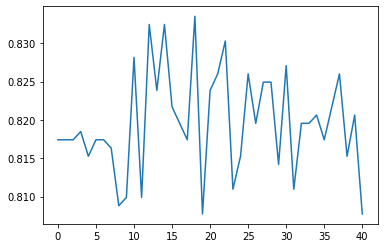

In [30]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate(test_data)
plt.show()

In [32]:
inference_model = build_infer_model(L)

inference_model.set_weights(model.get_weights())

In [33]:
inference_model([np.array([1,1,1,1]).reshape(1,-1), np.array(np.ones(20)/20).reshape(1,-1)])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.901889]], dtype=float32)>

In [34]:
tfjs.converters.save_keras_model(inference_model, "tfjs_model")

# Model Card

In [35]:
model_card = {
    'title': 'Hemolytic Prediction',
    'details': 'Recurrent (bi-LSTM) neural network for predicting if a peptide is hemolytic. Developed by Andrew White using data from The Database of Antimicrobial Activity and Structure of Peptides (DBAASP). '
    'The activity is defined from by extrapolating from a measurement assuming a dose response curves to the point at which 50% of RBCs are lysed.  If activity is below 100 μg / ml, it is hemolytic. Each measurement is treated independently, so sequences can appear multiple times.',
    'use': 'Peptides between 1 and 190 residues. L- and canonical  amino acids.',
    'factors': 'Dataset was from sequences thought to be antimicrobial or clinically relevant.',
    'metrics': f'Test accuracy {test_result[2]:.2f}. Test AUC {test_result[1]:.2f}',
    'evaluation': 'Withheld positive and negative examples',
    'training': f'{len(pos_data) + len(neg_data)} positive (length range: {np.min(pos_data_lengths)}-{np.max(pos_data_lengths)}) and negative (length range: {np.min(neg_data_lengths)}-{np.max(neg_data_lengths)}) sequences. Only L- and canonical amino acids were trained.',
    'caveats': 'The sequences tested were typically from biological sources.',
    'ethics': 'These predictions are not a substitute for labratory experiments.'
}
with open('card.json', 'w') as f:
  json.dump(model_card, f)
print(json.dumps(model_card, indent=True))

{
 "title": "Hemolytic Prediction",
 "details": "Recurrent (bi-LSTM) neural network for predicting if a peptide is hemolytic. Developed by Andrew White using data from The Database of Antimicrobial Activity and Structure of Peptides (DBAASP). The activity is defined from by extrapolating from a measurement assuming a dose response curves to the point at which 50% of RBCs are lysed.  If activity is below 100 \u03bcg / ml, it is hemolytic. Each measurement is treated independently, so sequences can appear multiple times.",
 "use": "Peptides between 2 and 190 residues. L- and canonical  amino acids.",
 "factors": "Dataset was from sequences thought to be antimicrobial or clinically relevant.",
 "metrics": "Test accuracy 0.82. Test AUC 0.82",
 "evaluation": "Withheld positive and negative examples",
 "training": "9316 positive and negative sequences. Only L- and canonical amino acids were trained.",
 "caveats": "The sequences tested were typically from biological sources.",
 "ethics": "The